In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
import warnings
warnings.filterwarnings("ignore")
from transformers import pipeline
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


In [2]:
df = pd.read_csv('Reviews.csv')
#If the dataset is not available then use the link below
# https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews?select=Reviews.csv
print(df.shape)
df = df.head(5000)
print(df.shape)

(568454, 10)
(5000, 10)


In [3]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [4]:
# Outliers check kijiye
df.isnull().sum()

Id                        0
ProductId                 0
UserId                    0
ProfileName               0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
Text                      0
dtype: int64

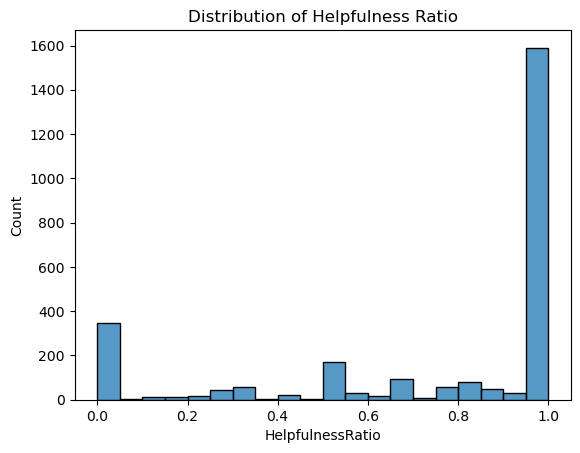

In [5]:
# Calculating the helpfulness ratio
df['HelpfulnessRatio'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator'].replace(0, np.nan)

# Distribution of helpfulness ratio
sns.histplot(df['HelpfulnessRatio'].dropna(), bins=20)
plt.title('Distribution of Helpfulness Ratio')
plt.show()

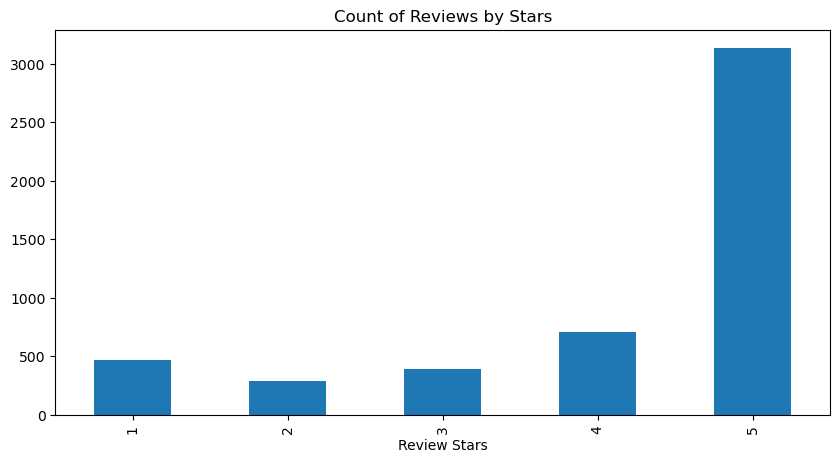

In [6]:
ax = df['Score'].value_counts().sort_index().plot(
    kind='bar', 
    title='Count of Reviews by Stars', 
    figsize=(10, 5)
)
ax.set_xlabel('Review Stars')
plt.show()


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Id                      5000 non-null   int64  
 1   ProductId               5000 non-null   object 
 2   UserId                  5000 non-null   object 
 3   ProfileName             5000 non-null   object 
 4   HelpfulnessNumerator    5000 non-null   int64  
 5   HelpfulnessDenominator  5000 non-null   int64  
 6   Score                   5000 non-null   int64  
 7   Time                    5000 non-null   int64  
 8   Summary                 5000 non-null   object 
 9   Text                    5000 non-null   object 
 10  HelpfulnessRatio        2642 non-null   float64
dtypes: float64(1), int64(5), object(5)
memory usage: 429.8+ KB


In [8]:
df['Score'].describe()

count    5000.000000
mean        4.150400
std         1.326549
min         1.000000
25%         4.000000
50%         5.000000
75%         5.000000
max         5.000000
Name: Score, dtype: float64

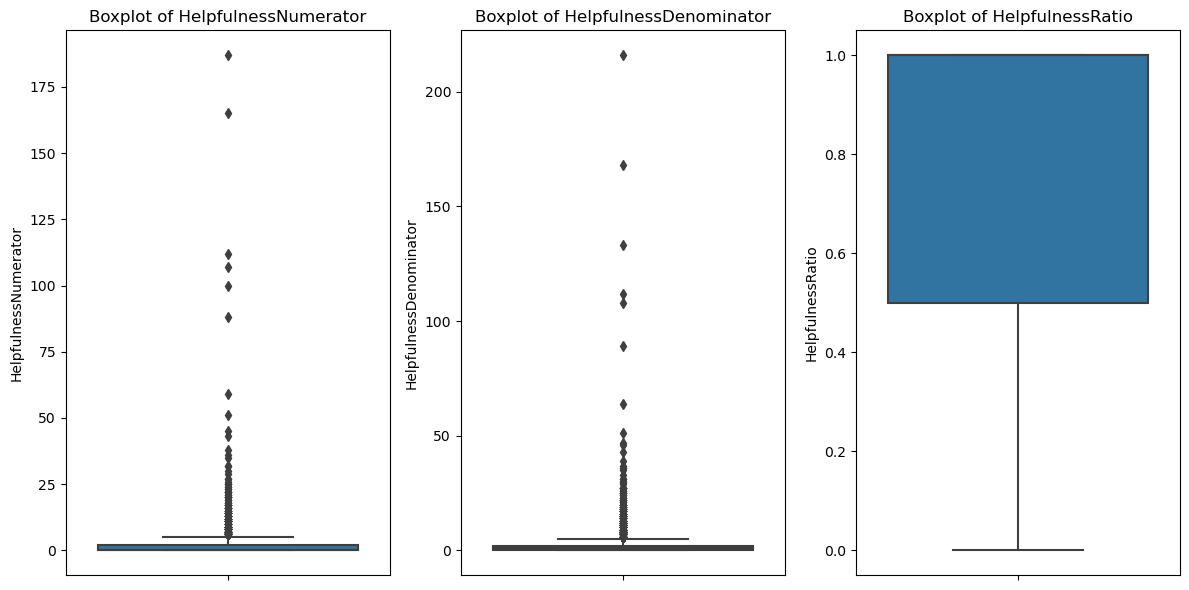

In [9]:

# Outliers in 'HelpfulnessNumerator', 'HelpfulnessDenominator'
numeric_cols = ['HelpfulnessNumerator', 'HelpfulnessDenominator', 'HelpfulnessRatio']

# Plotting boxplots for numeric columns
plt.figure(figsize=(12, 6))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(y=df[col])
    plt.title(f'Boxplot of {col}')
    
plt.tight_layout()
plt.show()


In [10]:
# Function to remove outliers using IQR
def remove_outliers_iqr(df, column):
    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    
    # Calculate Interquartile Range (IQR)
    IQR = Q3 - Q1
    
    # Define the lower and upper bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Remove rows with outliers
    df_cleaned = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df_cleaned

# Removing outliers from 'HelpfulnessNumerator'
df_cleaned = remove_outliers_iqr(df, 'HelpfulnessNumerator')

# Removing outliers from 'HelpfulnessDenominator'
df_cleaned = remove_outliers_iqr(df_cleaned, 'HelpfulnessDenominator')

df_cleaned = remove_outliers_iqr(df_cleaned, 'HelpfulnessRatio')

# Display the cleaned dataset
print("Dataset after removing outliers:")
df_cleaned.head()

Dataset after removing outliers:


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,HelpfulnessRatio
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,1.0
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,1.0
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,1.0
8,9,B000E7L2R4,A1MZYO9TZK0BBI,R. James,1,1,5,1322006400,Yay Barley,Right now I'm mostly just sprouting this so my...,1.0
10,11,B0001PB9FE,A3HDKO7OW0QNK4,Canadian Fan,1,1,5,1107820800,The Best Hot Sauce in the World,I don't know if it's the cactus or the tequila...,1.0


In [11]:
duplicates = df_cleaned.duplicated()

# Display rows that are duplicates
print("Duplicate rows:")
print(df_cleaned[duplicates])

# Count the number of duplicate rows
num_duplicates = duplicates.sum()
print(f"Number of duplicate rows: {num_duplicates}")

Duplicate rows:
Empty DataFrame
Columns: [Id, ProductId, UserId, ProfileName, HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary, Text, HelpfulnessRatio]
Index: []
Number of duplicate rows: 0


In [12]:
correlation_matrix = df_cleaned[['Score', 'HelpfulnessNumerator', 'HelpfulnessDenominator']].corr()

print("Correlation matrix:")
print(correlation_matrix)

Correlation matrix:
                           Score  HelpfulnessNumerator  HelpfulnessDenominator
Score                   1.000000              0.129058               -0.109442
HelpfulnessNumerator    0.129058              1.000000                0.740596
HelpfulnessDenominator -0.109442              0.740596                1.000000


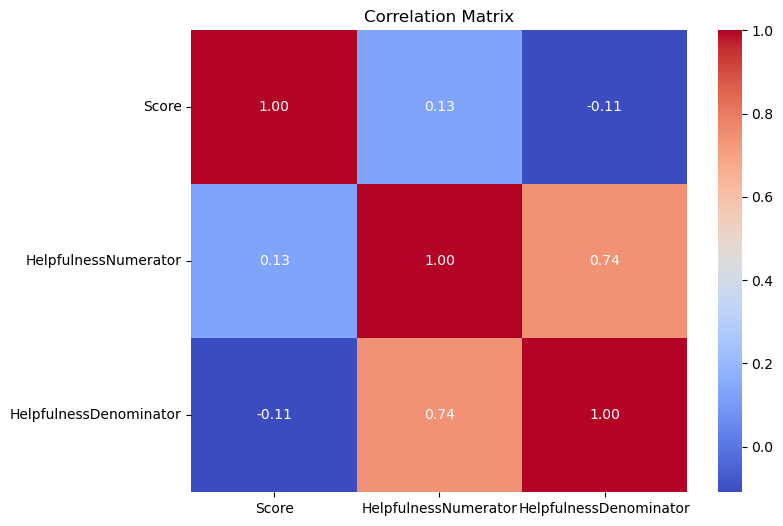

In [13]:
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()


In [14]:

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

# Text preprocessing function
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    
    # Tokenize the text
    tokens = word_tokenize(text)
    
    # Remove punctuation
    tokens = [word for word in tokens if word.isalpha()]
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    
    # Join tokens back to string
    processed_text = ' '.join(tokens)
    return processed_text

# Apply the text preprocessing to the 'Text' column
df['Processed_Text'] = df['Text'].apply(preprocess_text)

# Checking the processed text
df[['Text', 'Processed_Text']].head()


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lucif\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lucif\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Text,Processed_Text
0,I have bought several of the Vitality canned d...,bought several vitality canned dog food produc...
1,Product arrived labeled as Jumbo Salted Peanut...,product arrived labeled jumbo salted peanuts p...
2,This is a confection that has been around a fe...,confection around centuries light pillowy citr...
3,If you are looking for the secret ingredient i...,looking secret ingredient robitussin believe f...
4,Great taffy at a great price. There was a wid...,great taffy great price wide assortment yummy ...


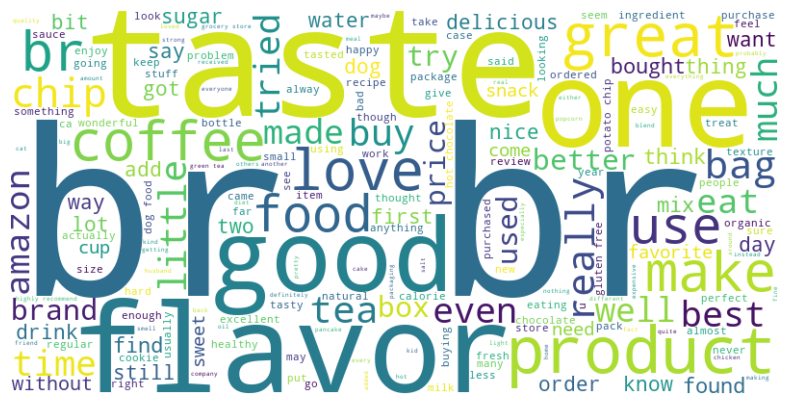

In [15]:
from wordcloud import WordCloud

# Generate a word cloud for the processed text
all_text = ' '.join(df['Processed_Text'].tolist())

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


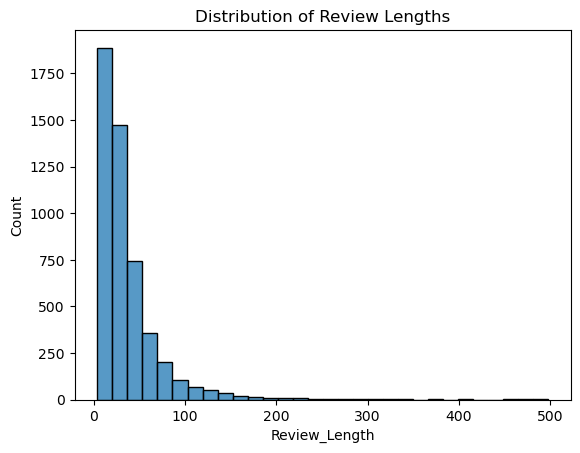

In [16]:
# Adding a column for the length of each review
df['Review_Length'] = df['Processed_Text'].apply(lambda x: len(x.split()))

# Plotting the distribution of review lengths
sns.histplot(df['Review_Length'], bins=30)
plt.title('Distribution of Review Lengths')
plt.show()


In [17]:
df['Processed_Text'] = df['Text'].str.lower().str.replace('[^a-z\s]', '', regex=True)

In [18]:
# VADER Sentiment Analysis
vader_analyzer = SentimentIntensityAnalyzer()

def vader_sentiment(text):
    scores = vader_analyzer.polarity_scores(text)
    if scores['compound'] >= 0.05:
        return 'Positive'
    elif scores['compound'] <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

df['VADER_Sentiment'] = df['Processed_Text'].apply(vader_sentiment)
df[['Processed_Text', 'VADER_Sentiment']].head()

,Processed_Text,VADER_Sentiment
0,i have bought several of the vitality canned d...,Positive
1,product arrived labeled as jumbo salted peanut...,Negative
2,this is a confection that has been around a fe...,Positive
3,if you are looking for the secret ingredient i...,Positive
4,great taffy at a great price there was a wide...,Positive


In [27]:
# RoBERTa Sentiment Analysis using Hugging Face
roberta_pipeline = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment")

def roberta_sentiment(text):
    result = roberta_pipeline(text[:512])  # Limit input size for compatibility
    return result[0]['label']

df['RoBERTa_Sentiment'] = df['Processed_Text'].apply(roberta_sentiment)
df[['Processed_Text', 'RoBERTa_Sentiment']].head()

,Processed_Text,RoBERTa_Sentiment
0,i have bought several of the vitality canned d...,Positive
1,product arrived labeled as jumbo salted peanut...,Negative
2,this is a confection that has been around a fe...,Positive
3,if you are looking for the secret ingredient i...,Positive
4,great taffy at a great price there was a wide...,Positive


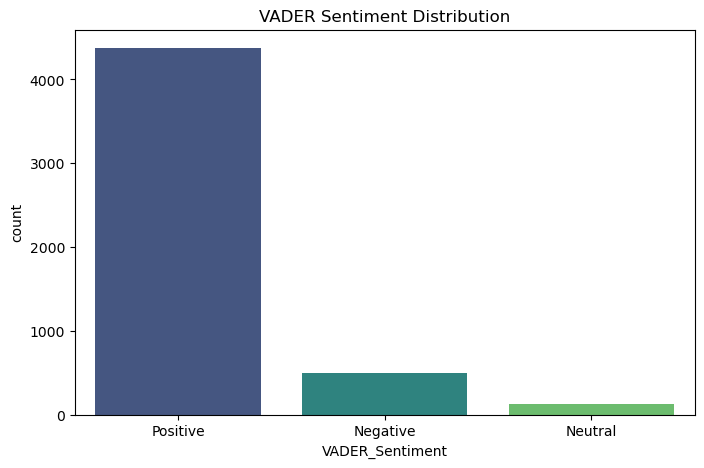

In [20]:
# VADER sentiment distribution
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='VADER_Sentiment', palette='viridis')
plt.title('VADER Sentiment Distribution')
plt.show()

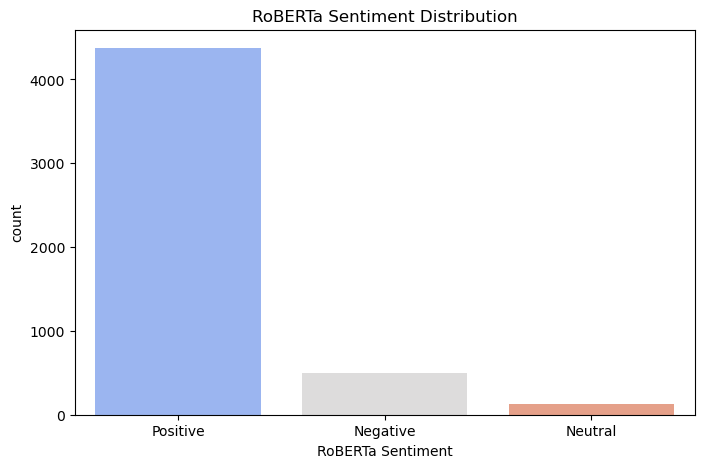

In [22]:
# RoBERTa sentiment distribution
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='RoBERTa_Sentiment', palette='coolwarm')
plt.title('RoBERTa Sentiment Distribution')
plt.show()

In [25]:
# Custom input for testing VADER and RoBERTa models
test_text = "The product quality is amazing, and I would definitely recommend it!"
test_text1 = "The product quality is very bad, and I would not recommend it!"

# VADER analysis
print("VADER Sentiment:", vader_sentiment(test_text))
print("VADER Sentiment:", vader_sentiment(test_text1))

# RoBERTa analysis
print("RoBERTa Sentiment:", roberta_sentiment(test_text))
print("RoBERTa Sentiment:", roberta_sentiment(test_text1))


VADER Sentiment: Positive
VADER Sentiment: Negative
RoBERTa Sentiment: Positive
RoBERTa Sentiment: Negative
